## Configurações iniciais para utilizar o Spark no Google Colab:

In [78]:
# instalar as dependências:
!apt-get update -qq
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q https://archive.apache.org/dist/spark/spark-3.1.2/spark-3.1.2-bin-hadoop2.7.tgz
!tar xf spark-3.1.2-bin-hadoop2.7.tgz
!pip install -q findspark

W: Skipping acquire of configured file 'main/source/Sources' as repository 'https://r2u.stat.illinois.edu/ubuntu jammy InRelease' does not seem to provide it (sources.list entry misspelt?)


In [79]:
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.1.2-bin-hadoop2.7"

In [80]:
import findspark
findspark.init()

In [81]:
from pyspark.sql import SparkSession

spark = SparkSession.builder \
    .master('local[*]') \
    .appName("ETL Lojinha") \
    .config('spark.ui.port', '4050') \
    .getOrCreate()

## Carregamento de Dados:

In [82]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [83]:
path = '/content/drive/MyDrive/Estácio/Tópicos de Big Data em Python/Dataset projeto lojinha.csv'
dados = spark.read.csv(path, sep=',', inferSchema=True, header=True)

## Manipulando os Dados:

In [84]:
dados.limit(5).toPandas()

,CNPJ,Razão Social,Data do Processamento,Data da Transação,Rede Captura,Descrição,Número do cartão,Nº de Autorização,Valor Bruto R$,Data de Pagamento
0,41.890.685/0001-76,RICARDO DOS SANTOS ALVES 38005572824,16/08/2024,15/08/2024,PAGSEGURO,COMPRAS,6060********3012,406249,"R$199,85",12/09/2024
1,41.890.685/0001-76,RICARDO DOS SANTOS ALVES 38005572824,16/08/2024,15/08/2024,PAGSEGURO,COMPRAS,6060********8403,706148,"R$199,65",12/09/2024
2,41.890.685/0001-76,RICARDO DOS SANTOS ALVES 38005572824,16/08/2024,15/08/2024,PAGSEGURO,COMPRAS,6060********5343,706150,"R$198,75",12/09/2024
3,41.890.685/0001-76,RICARDO DOS SANTOS ALVES 38005572824,16/08/2024,15/08/2024,PAGSEGURO,COMPRAS,6060********7446,406247,"R$198,00",12/09/2024
4,41.890.685/0001-76,RICARDO DOS SANTOS ALVES 38005572824,16/08/2024,15/08/2024,PAGSEGURO,COMPRAS,6060********8596,406245,"R$198,00",12/09/2024


In [86]:
# Verificando os tipos de dados de cada coluna
dados.printSchema()

root
 |-- CNPJ: string (nullable = true)
 |-- Razão Social: string (nullable = true)
 |-- Data do Processamento: string (nullable = true)
 |-- Data da Transação: string (nullable = true)
 |-- Rede Captura: string (nullable = true)
 |-- Descrição: string (nullable = true)
 |-- Número do cartão: string (nullable = true)
 |-- Nº de Autorização: integer (nullable = true)
 |-- Valor Bruto R$: string (nullable = true)
 |-- Data de Pagamento: string (nullable = true)



### Ajustando os tipos de dados:

#### De String para DateType:

In [9]:
from pyspark.sql.functions import to_date, col, date_format

In [87]:
dados = dados.withColumn("Data do Processamento", to_date(col("Data do Processamento"), "dd/MM/yyyy"))\
             .withColumn("Data da Transação", to_date(col("Data da Transação"), "dd/MM/yyyy"))\
             .withColumn("Data de Pagamento", to_date(col("Data de Pagamento"), "dd/MM/yyyy"))

In [88]:
dados.printSchema()

root
 |-- CNPJ: string (nullable = true)
 |-- Razão Social: string (nullable = true)
 |-- Data do Processamento: date (nullable = true)
 |-- Data da Transação: date (nullable = true)
 |-- Rede Captura: string (nullable = true)
 |-- Descrição: string (nullable = true)
 |-- Número do cartão: string (nullable = true)
 |-- Nº de Autorização: integer (nullable = true)
 |-- Valor Bruto R$: string (nullable = true)
 |-- Data de Pagamento: date (nullable = true)



#### De Integer para String:

In [92]:
dados = dados.withColumn("Nº de Autorização", col("Nº de Autorização").cast("string"))

In [91]:
dados.printSchema()

root
 |-- CNPJ: string (nullable = true)
 |-- Razão Social: string (nullable = true)
 |-- Data do Processamento: date (nullable = true)
 |-- Data da Transação: date (nullable = true)
 |-- Rede Captura: string (nullable = true)
 |-- Descrição: string (nullable = true)
 |-- Número do cartão: string (nullable = true)
 |-- Nº de Autorização: string (nullable = true)
 |-- Valor Bruto R$: string (nullable = true)
 |-- Data de Pagamento: date (nullable = true)



#### De String para DecimalType:

In [93]:
from pyspark.sql.types import DecimalType

In [94]:
from pyspark.sql.functions import regexp_replace, col

In [95]:
dados = dados.withColumn("Valor Bruto R$", regexp_replace(col("Valor Bruto R$"), "R\\$", "")) \
             .withColumn("Valor Bruto R$", regexp_replace(col("Valor Bruto R$"), ",", "."))\
             .withColumn("Valor Bruto R$", col("Valor Bruto R$").cast(DecimalType(10, 2)))

In [96]:
dados.printSchema()

root
 |-- CNPJ: string (nullable = true)
 |-- Razão Social: string (nullable = true)
 |-- Data do Processamento: date (nullable = true)
 |-- Data da Transação: date (nullable = true)
 |-- Rede Captura: string (nullable = true)
 |-- Descrição: string (nullable = true)
 |-- Número do cartão: string (nullable = true)
 |-- Nº de Autorização: string (nullable = true)
 |-- Valor Bruto R$: decimal(10,2) (nullable = true)
 |-- Data de Pagamento: date (nullable = true)



In [97]:
dados.toPandas()

,CNPJ,Razão Social,Data do Processamento,Data da Transação,Rede Captura,Descrição,Número do cartão,Nº de Autorização,Valor Bruto R$,Data de Pagamento
0,41.890.685/0001-76,RICARDO DOS SANTOS ALVES 38005572824,2024-08-16,2024-08-15,PAGSEGURO,COMPRAS,6060********3012,406249,199.85,2024-09-12
1,41.890.685/0001-76,RICARDO DOS SANTOS ALVES 38005572824,2024-08-16,2024-08-15,PAGSEGURO,COMPRAS,6060********8403,706148,199.65,2024-09-12
2,41.890.685/0001-76,RICARDO DOS SANTOS ALVES 38005572824,2024-08-16,2024-08-15,PAGSEGURO,COMPRAS,6060********5343,706150,198.75,2024-09-12
3,41.890.685/0001-76,RICARDO DOS SANTOS ALVES 38005572824,2024-08-16,2024-08-15,PAGSEGURO,COMPRAS,6060********7446,406247,198.00,2024-09-12
4,41.890.685/0001-76,RICARDO DOS SANTOS ALVES 38005572824,2024-08-16,2024-08-15,PAGSEGURO,COMPRAS,6060********8596,406245,198.00,2024-09-12
...,...,...,...,...,...,...,...,...,...,...
419,41.890.685/0001-76,RICARDO DOS SANTOS ALVES 38005572824,2024-07-02,2024-07-01,PAGSEGURO,COMPRAS,6060********1191,705861,1.00,2024-08-01
420,41.890.685/0001-76,RICARDO DOS SANTOS ALVES 38005572824,2024-07-02,2024-07-01,PAGSEGURO,COMPRAS,6060********2016,405930,1.00,2024-08-01
421,41.890.685/0001-76,RICARDO DOS SANTOS ALVES 38005572824,2024-07-02,2024-07-01,PAGSEGURO,COMPRAS,6060********8596,405931,1.00,2024-08-01
422,41.890.685/0001-76,RICARDO DOS SANTOS ALVES 38005572824,2024-07-02,2024-07-01,PAGSEGURO,COMPRAS,6060********7696,405928,1.00,2024-08-01


### Analisando os dados:

#### Verificando o valor total do caixa no período:

In [98]:
from pyspark.sql.functions import col, sum as sum_

In [99]:
caixa = dados.agg(sum_("Valor Bruto R$").alias("caixa")).collect()[0]["caixa"]

In [100]:
print(f"O valor total do caixa no período foi de {caixa} reais")

O valor total do caixa no período foi de 53049.47 reais


#### Verificando a quantidade total de pagamentos realizados no período:

In [103]:
from pyspark.sql.functions import count

In [104]:
dados.agg(count("*").alias("Número total de Pagamentos")).show()

+--------------------------+
|Número total de Pagamentos|
+--------------------------+
|                       424|
+--------------------------+



#### Verificando o somatório dos pagamentos realizados no período:

In [105]:
from pyspark.sql.functions import sum as sum_

In [106]:
valor_total_de_entrada = dados.select(sum_("Valor Bruto R$")).collect()[0][0]

In [107]:
# Exibe o resultado
print(f"O valor total de entrada no período foi de {valor_total_de_entrada} reais")

O valor total de entrada no período foi de 53049.47 reais


#### Verificando a quantidade média de compras realizadas por dia:

In [108]:
from pyspark.sql.functions import col, count, avg

In [110]:
# Agrupar por "Data de Pagamento" e contar o número de pagamentos para cada data
media_compras_por_data = dados.groupBy("Data de Pagamento").agg(count("*").alias("Quantidade de Pagamentos"))

# Calcular a média da quantidade de pagamentos
media_compras = media_compras_por_data.agg(avg("Quantidade de Pagamentos").alias("Quantidade média de compras por dia"))

# Mostrar o resultado
media_compras.show()

+-----------------------------------+
|Quantidade média de compras por dia|
+-----------------------------------+
|                  60.57142857142857|
+-----------------------------------+



#### Verificando o valor total médio das compras realizadas por dia:

In [111]:
from pyspark.sql.functions import col, sum, avg, format_number

In [112]:
# Agrupar por "Data de Pagamento" e somar o valor total de "Valor Bruto R$" para cada data
total_por_data = dados.groupBy("Data de Pagamento").agg(sum("Valor Bruto R$").alias("Total por Data"))

# Calcular a média dos totais diários
media_total_por_data = total_por_data.agg(avg("Total por Data").alias("Valor Total Médio por Dia"))

# Formatar o resultado para duas casas decimais
media_total_por_data_formatado = media_total_por_data.withColumn(
    "Valor Total Médio por Dia",
    format_number(col("Valor Total Médio por Dia"), 2)
)

# Mostrar o resultado
media_total_por_data_formatado.show()

+-------------------------+
|Valor Total Médio por Dia|
+-------------------------+
|                 7,578.50|
+-------------------------+



##### Verificando os valores totais do caixa por agrupamento de datas:

In [113]:
from pyspark.sql.functions import year, month, date_format

In [114]:
# Adiciona coluna para o dia da semana
dados_transformados = dados.withColumn("Dia da Semana", date_format(col("Data da Transação"), "EEEE"))\
                           .withColumn("Mês", date_format(col("Data da Transação"), "MMMM"))

# Excluir as colunas 'Data do Processamento' e 'Data de Pagamento'
dados_transformados = dados_transformados.drop('Data do Processamento', 'Data de Pagamento')

#Exibindo o DataFrame
dados_transformados.show(truncate=False)

+------------------+------------------------------------+-----------------+------------+---------+----------------+-----------------+--------------+-------------+------+
|CNPJ              |Razão Social                        |Data da Transação|Rede Captura|Descrição|Número do cartão|Nº de Autorização|Valor Bruto R$|Dia da Semana|Mês   |
+------------------+------------------------------------+-----------------+------------+---------+----------------+-----------------+--------------+-------------+------+
|41.890.685/0001-76|RICARDO DOS SANTOS ALVES 38005572824|2024-08-15       |PAGSEGURO   |COMPRAS  |6060********3012|406249           |199.85        |Thursday     |August|
|41.890.685/0001-76|RICARDO DOS SANTOS ALVES 38005572824|2024-08-15       |PAGSEGURO   |COMPRAS  |6060********8403|706148           |199.65        |Thursday     |August|
|41.890.685/0001-76|RICARDO DOS SANTOS ALVES 38005572824|2024-08-15       |PAGSEGURO   |COMPRAS  |6060********5343|706150           |198.75        |Th

In [115]:
dados_transformados.printSchema()

root
 |-- CNPJ: string (nullable = true)
 |-- Razão Social: string (nullable = true)
 |-- Data da Transação: date (nullable = true)
 |-- Rede Captura: string (nullable = true)
 |-- Descrição: string (nullable = true)
 |-- Número do cartão: string (nullable = true)
 |-- Nº de Autorização: string (nullable = true)
 |-- Valor Bruto R$: decimal(10,2) (nullable = true)
 |-- Dia da Semana: string (nullable = true)
 |-- Mês: string (nullable = true)



In [117]:
dados_transformados.createOrReplaceTempView("soma_valores_por_dia_da_semana")

# Executar uma consulta SQL para agrupar os valores por dia da semana
resultado = spark.sql("""
    SELECT `Dia da Semana`, SUM(`Valor Bruto R$`) AS `Valor Bruto R$`
    FROM soma_valores_por_dia_da_semana
    GROUP BY `Dia da Semana`
    ORDER BY `Valor Bruto R$` DESC
""")

# Mostrar o resultado
resultado.show()

+-------------+--------------+
|Dia da Semana|Valor Bruto R$|
+-------------+--------------+
|       Monday|      10248.20|
|     Saturday|       9266.78|
|    Wednesday|       8907.50|
|      Tuesday|       8377.12|
|     Thursday|       7644.70|
|       Friday|       7009.77|
|       Sunday|       1595.40|
+-------------+--------------+



###### Com a análise acima podemos verificar que o dia da semana com maior valor em vendas foi a SEGUNDA-FEIRA e o dia com menor valor em vendas foi o DOMINGO.

#### Verificando o total de transações realizadas por dia da semana:

In [120]:
# Registrar o DataFrame como uma tabela temporária
dados_transformados.createOrReplaceTempView("quantidade_transacoes_por_dia_da_semana")

# Executar uma consulta SQL para contar o número de transações por dia da semana
resultado = spark.sql("""
    SELECT `Dia da Semana`, COUNT(*) AS total_transacoes
    FROM quantidade_transacoes_por_dia_da_semana
    GROUP BY `Dia da Semana`
    ORDER BY total_transacoes DESC
""")

# Mostrar o resultado
resultado.show()


+-------------+----------------+
|Dia da Semana|total_transacoes|
+-------------+----------------+
|       Monday|              80|
|    Wednesday|              74|
|     Thursday|              68|
|      Tuesday|              67|
|     Saturday|              62|
|       Friday|              62|
|       Sunday|              11|
+-------------+----------------+



###### Com a análise acima podemos verificar que os dias da semana com maior quantidade de compras realizadas foram a SEGUNDA e QUARTA-FEIRA. Com esta informação, podemor inferir que os melhores dias para se realizar uma ação como uma campanha de marketing, por exemplo, seriam a segunda-feira e a quarta-feira, pois a campanha atingiria mais clientes nestes dias.

### Exibindo gráficos:

#### Série temporal:

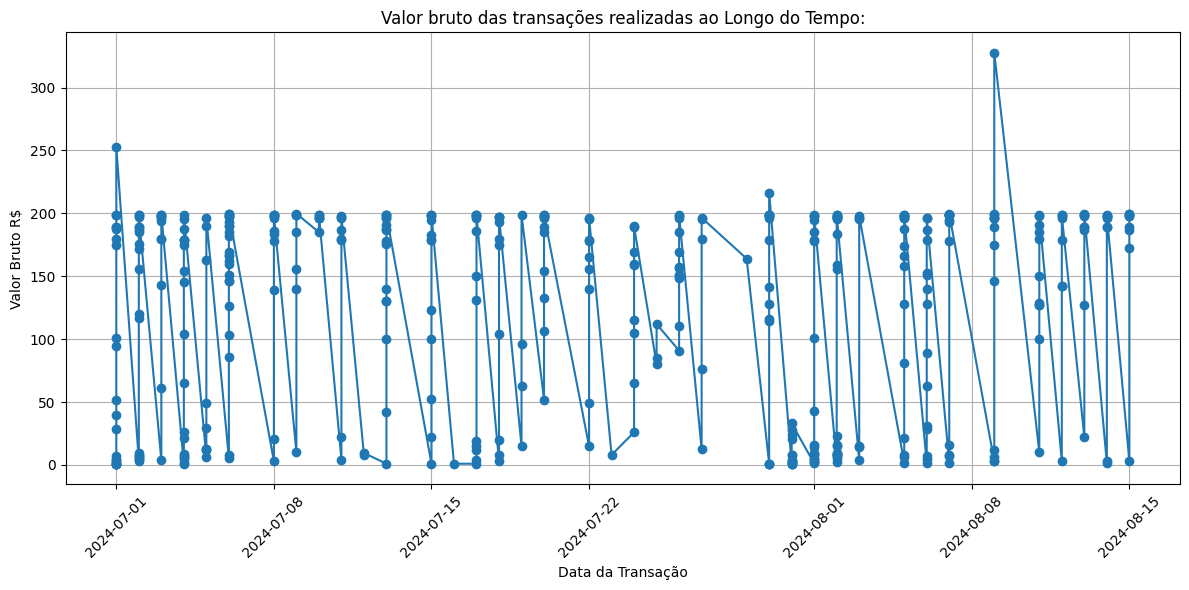

In [56]:
import pandas as pd
import matplotlib.pyplot as plt

dados_plt = dados.toPandas()
dados_plt.set_index("Data da Transação", inplace=True)

# Plotar o gráfico
plt.figure(figsize=(12, 6))
plt.plot(dados_plt.index, dados_plt["Valor Bruto R$"], marker='o', linestyle='-')
plt.title('Valor bruto das transações realizadas ao Longo do Tempo:')
plt.xlabel('Data da Transação')
plt.ylabel('Valor Bruto R$')
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()

##### No gráfico acima cada ponto representa uma transação (compra) realizada e a altura do ponto no eixo Y representa o valor desta compra. No eixo X está representada a informação temporal das diferentes datas onde cada transação foi realizada.

#### Histograma:

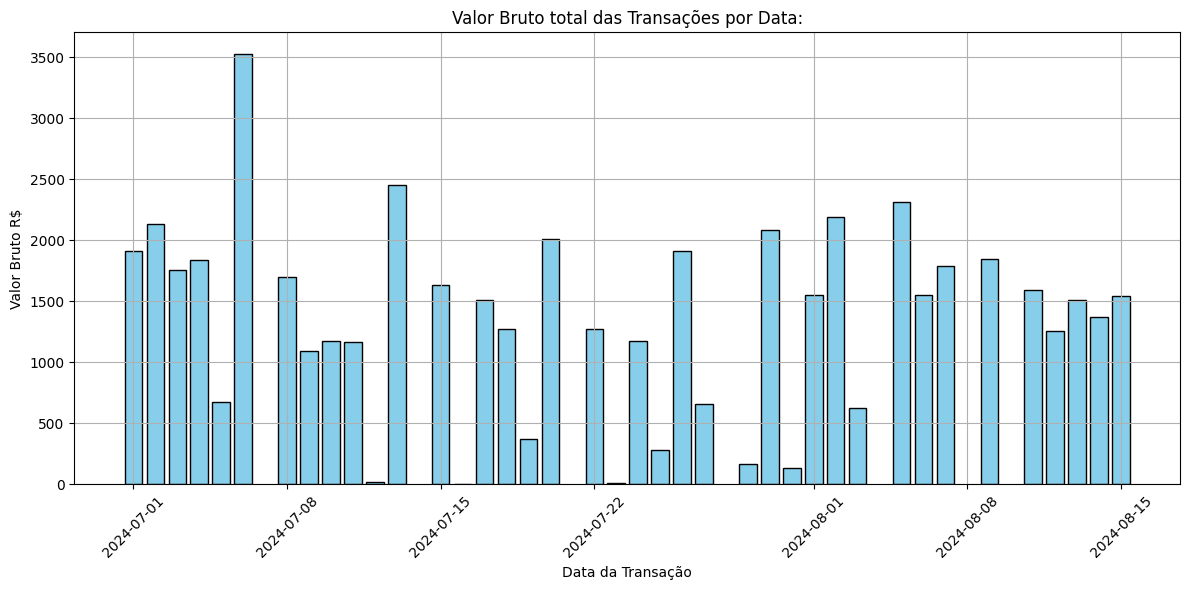

In [64]:
import pandas as pd
import matplotlib.pyplot as plt

# Converter o DataFrame do Spark para Pandas
dados_plt = dados.toPandas()

# Agrupar os dados por data e somar os valores brutos
dados_plt_grouped = dados_plt.groupby('Data da Transação')['Valor Bruto R$'].sum().reset_index()

# Plotar o gráfico de barras
plt.figure(figsize=(12, 6))
plt.bar(dados_plt_grouped['Data da Transação'], dados_plt_grouped['Valor Bruto R$'], color='skyblue', edgecolor='black')
plt.title('Valor Bruto total das Transações por Data:')
plt.xlabel('Data da Transação')
plt.ylabel('Valor Bruto R$')
plt.grid(True)

# Ajustar a rotação das datas no eixo X para melhor visualização
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

##### No gráfico acima cada barra com sua respectiva altura no eixo Y representa o valor total das compras realizadas. No eixo X está representada a informação temporal das datas onde as transações foram realizadas.